In [46]:
import matplotlib
import matplotlib.pyplot as plt
import json
import seaborn as sns
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from dateutil.parser import parse
from datetime import timedelta

In [47]:
results_dir = "results/loss"

results_options = [f"{results_dir}/{f}" for f in os.listdir(f"{results_dir}") if os.path.isdir(f"{results_dir}/{f}")]
results_options.sort()

# results_dir = "results/2022-01-07T11:40:21+00:00"

results_dir = results_options[-1]
print(f"results_dir: {results_dir}")

results_dir: results/loss/2022-01-24T12:00:25+00:00


In [48]:
results = [f for f in os.listdir(results_dir) if f.endswith("json") and f.startswith("PodStartupLatency")]
configs = [f for f in os.listdir(results_dir) if f.endswith("json") and f.startswith("config")]

results.sort()
configs.sort()

df = pd.DataFrame()
for (config, r) in zip(configs, results):
    with open(f"{results_dir}/{config}", "r") as c:
        with open(f"{results_dir}/{r}") as r:
            
            config_json = json.loads(c.read())
            results_json = json.loads(r.read())
            
            rows_json = defaultdict(list)

            for item in results_json["dataItems"]:
                name = item["labels"]["Metric"]
                data = item["raw"]
                rows_json["metric"] += [name for _ in range(len(data))]
                
                starts = [parse(d["start"]) for d in data]
                start = min(starts)
                rows_json["start"] += [parse(d["start"]) - start for d in data]
                rows_json["start_ms"] += [(parse(d["start"])- start) / timedelta(milliseconds=1)  for d in data]

                rows_json["end"] += [parse(d["end"]) - start for d in data]
                rows_json["end_ms"] += [(parse(d["end"]) - start) / timedelta(milliseconds=1) for d in data]
                
                rows_json["measurement"] += [(parse(d["end"]) - parse(d["start"])) / timedelta(milliseconds=1) for d in data]

            for k, v in config_json.items():
                rows_json[k] = [v for _ in range(len(rows_json["metric"]))]
            
            d = pd.DataFrame(rows_json)
            df = df.append(d, ignore_index=True)

In [49]:
df.describe()

,start,start_ms,end,end_ms,measurement,partitioned,masters
count,780,780.000000,780,780.000000,780.000000,780.000000,780.0
mean,0 days 00:00:19.029007789,19029.007790,0 days 00:00:23.433678162,23433.678163,4404.670373,0.500000,3.0
std,0 days 00:00:22.871377780,22871.377781,0 days 00:00:27.560567836,27560.567836,15439.360636,0.500321,0.0
min,0 days 00:00:00,0.000000,0 days 00:00:00,0.000000,0.000000,0.000000,3.0
25%,0 days 00:00:04.999371500,4999.371500,0 days 00:00:05.412006,5412.006000,0.000000,0.000000,3.0
50%,0 days 00:00:10.054705500,10054.705500,0 days 00:00:11.434502500,11434.502500,339.513500,0.500000,3.0
75%,0 days 00:00:18,18000.000000,0 days 00:00:20.865683750,20865.683750,1492.911000,1.000000,3.0
max,0 days 00:01:31.526602,91526.602000,0 days 00:01:32.691218,92691.218000,89691.218000,1.000000,3.0


In [50]:
df.head()

,metric,start,start_ms,end,end_ms,measurement,partitioned,masters,image
0,client_started_to_client_initialized,0 days 00:00:05.050927,5050.927,0 days 00:00:05.050927,5050.927,0.0,0,3,etcd
1,client_started_to_client_initialized,0 days 00:00:11.693250,11693.250,0 days 00:00:11.693250,11693.250,0.0,0,3,etcd
2,client_started_to_client_initialized,0 days 00:00:14.336482,14336.482,0 days 00:00:14.336482,14336.482,0.0,0,3,etcd
3,client_started_to_client_initialized,0 days 00:00:04.027296,4027.296,0 days 00:00:04.027296,4027.296,0.0,0,3,etcd
4,client_started_to_client_initialized,0 days 00:00:07.552886,7552.886,0 days 00:00:07.552886,7552.886,0.0,0,3,etcd


In [51]:
master_counts = sorted(list(set(df["masters"])))
data_per_masters = [df[df["masters"] == i] for i in master_counts]

In [52]:
def stripbar(data):
    for image in set(data.image):
        print(image)
        partitioned = (sorted(list(set(data.partitioned))))
        g = sns.FacetGrid(data, col="masters")
        np.random.seed(100)
        g.map(sns.stripplot, "partitioned", "measurement", order=partitioned)
        np.random.seed(100)
        g.map(sns.barplot, "partitioned", "measurement", alpha=0.2, order=partitioned)
        g.set(xlabel="Partitioned", ylabel="Duration (ms)")
        plt.show()
        ax = sns.scatterplot(data=data[data.image == image], x="start_ms", y="measurement", alpha=0.7, hue="partitioned")
        ax.set(xlabel="Time since start (ms)", ylabel="Duration (ms)")
        plt.show()
        ax = sns.lineplot(data=data[data.image == image], x="start_ms", y="measurement", hue="partitioned")
        ax.set(xlabel="Time since start (ms)", ylabel="Duration (ms)")
        plt.show()

etcd


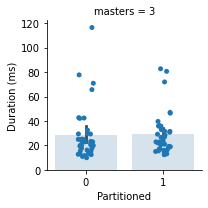

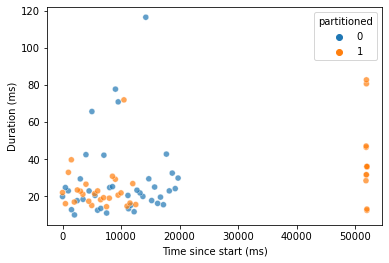

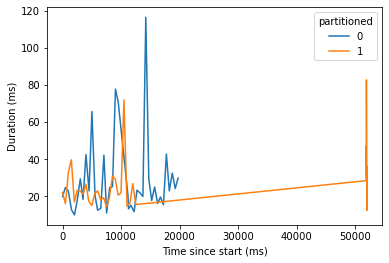

In [53]:
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]
stripbar(data)

etcd


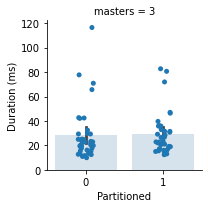

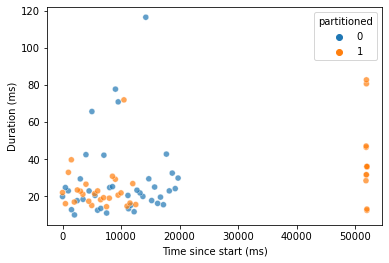

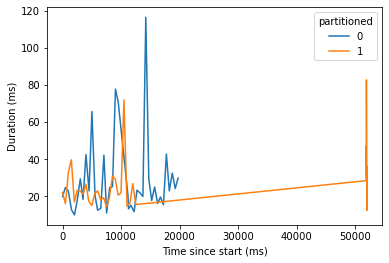

In [54]:
data = df[np.isin(df.metric, ["client_create_to_client_schedule"])]
data = data[data.measurement < 500] # cut off outliers
stripbar(data)

etcd


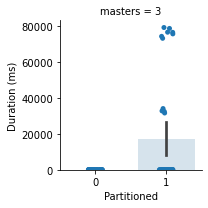

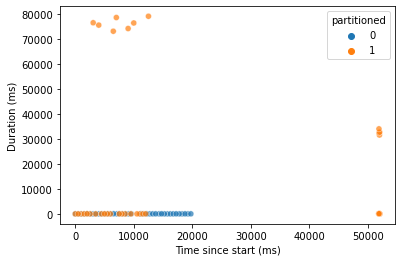

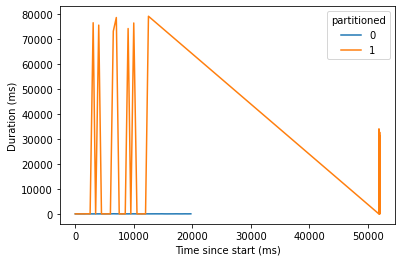

In [55]:
data = df[np.isin(df.metric, ["client_schedule_to_client_started"])]
stripbar(data)

etcd


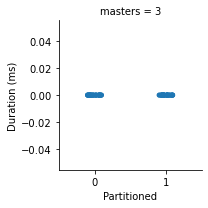

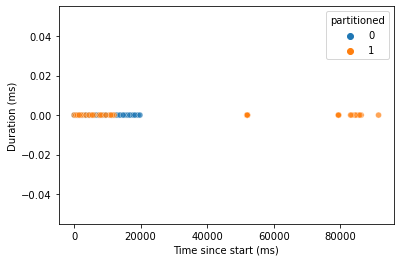

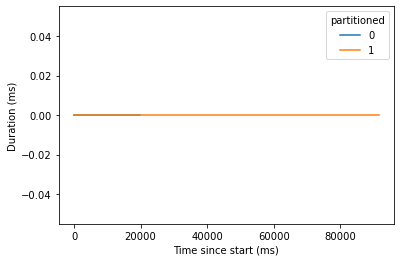

In [56]:
data = df[np.isin(df.metric, ["client_started_to_client_initialized"])]
stripbar(data)

etcd


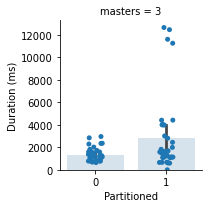

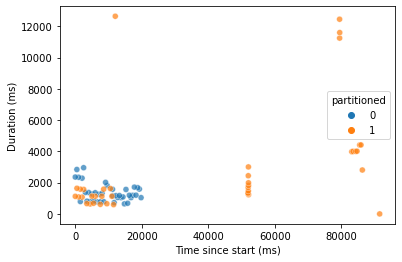

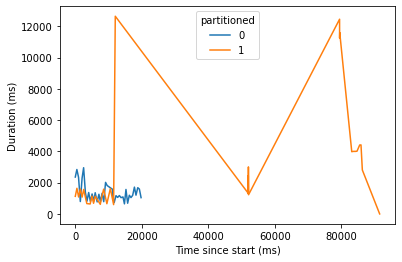

In [57]:
data = df[np.isin(df.metric, ["client_initialized_to_client_containersready"])]
stripbar(data)

etcd


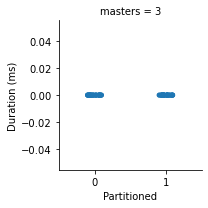

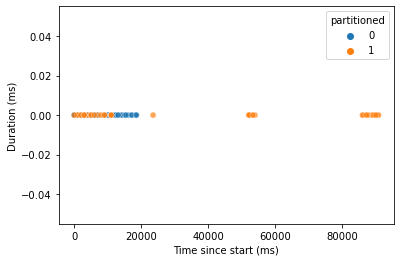

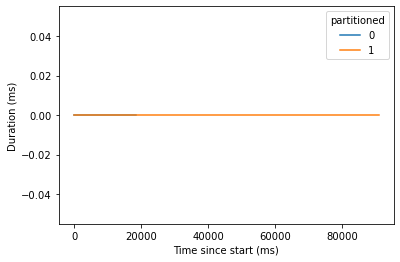

In [58]:
data = df[np.isin(df.metric, ["client_containersready_to_client_podready"])]
stripbar(data)